In [18]:
import itertools
import importlib
from functools import reduce, partial
import operator

import pennylane as qml
from pennylane import numpy as np
import numpy as nnp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import torch
# torch.set_default_dtype(torch.float32)
# mps_device = torch.device("mps")
# torch.set_default_device(mps_device)
# from torchinfo import summary

import tensorflow as tf
from silence_tensorflow import silence_tensorflow
tf.keras.backend.set_floatx('float32')
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
# import warnings
# import traceback

# warnings.simplefilter("error")
# warnings.simplefilter("once", category=qml.PennyLaneDeprecationWarning)

In [20]:
from src.layers import *

In [21]:
SEED = 42
nnp.random.seed(SEED)
np.random.seed(SEED)
# torch.manual_seed(42)
tf.random.set_seed(SEED)

# Data Generation

In [22]:
def generate_dataset_4(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical horizontal left diagonal or right diagonal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.25:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(0)  # Label for vertical line
        elif np.random.rand() < 0.5:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1)
        elif np.random.rand() < 0.75:
            # Left diagonal line
            for j in range(size):
                image[j, j] = 255
            labels.append(2)
        else:
            # Right diagonal line
            for j in range(size):
                image[j, size - j - 1] = 255
            labels.append(3)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    labels = np.array(labels)
    labels = ((-1 * np.ones((4,4))) + (2 * np.eye(4)))[labels]
    return nnp.array(images), nnp.array(labels).astype(nnp.float32)

def generate_dataset_2(num_images: int, size: int = 4, noise: float = 0.15):
    """Generate a vertical or horizontal line on the grid and then add noise in to it"""
    images = []
    labels = []

    for _ in range(num_images):
        # Create a blank image
        image = np.zeros((size, size), dtype=np.uint16)
        # Randomly choose a line orientation
        if np.random.rand() < 0.5:
            # Vertical line
            x = np.random.randint(0, size)
            image[:, x] = 255
            labels.append(-1.0)  # Label for vertical line
        else:
            # Horizontal line
            y = np.random.randint(0, size)
            image[y, :] = 255
            labels.append(1.0)

        # Add noise to the image
        noise_matrix = np.random.normal(0, noise * 255, (size, size))
        image = np.clip(image + noise_matrix, 0.0, 255.0)
        images.append(image.astype(np.float32) / 255.0)

    # one hot encode the labels
    # labels = np.array(labels)
    # labels = np.eye(2)[labels]
    return nnp.array(images), nnp.array(labels).astype(nnp.float32)

In [23]:
images, labels = generate_dataset_2(120, noise=0.1)

# Split the data
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# NOTE: Pennylane will freak out if the number of training images is not divisible by the batch size
test_labels.dtype, test_images.dtype

(dtype('float32'), dtype('float32'))

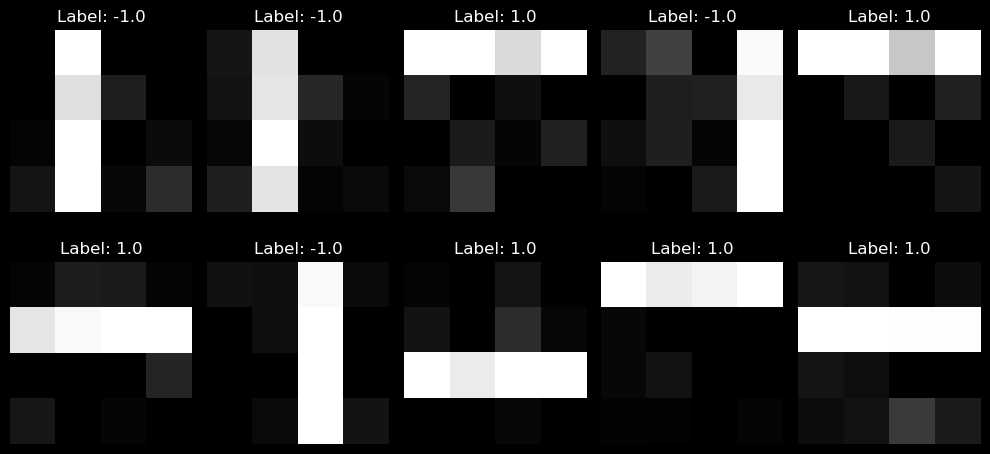

In [24]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(int(train_images.shape[1]), int(train_images.shape[2])), cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [25]:
train_images, test_images = nnp.array([hots_to_sv(img.flatten()) for img in train_images]), nnp.array([hots_to_sv(img.flatten()) for img in test_images])

In [26]:
train_images, train_labels = tf.convert_to_tensor(train_images), tf.convert_to_tensor(train_labels)
test_images, test_labels = tf.convert_to_tensor(test_images), tf.convert_to_tensor(test_labels)
train_images.dtype, train_labels.dtype, test_images.dtype, test_labels.dtype, train_images.device, train_images.shape

(tf.complex64,
 tf.float32,
 tf.complex64,
 tf.float32,
 '/job:localhost/replica:0/task:0/device:GPU:0',
 TensorShape([84, 65536]))

# Creating Circuit

In [27]:
assert train_images.shape[1] ** 0.5 % 1 == 0, "The input image size must be a perfect square"
B = 4
N = 4
w = N**2 # + B
dev = qml.device("default.qubit", wires=w)
wire_arr = nnp.arange(N**2, dtype=nnp.int32).reshape(N, N)

KERNEL_SIZE = 2
KERNEL_LAYERS = 2 # two was working pretty well
STRIDE = 1

In [28]:
# @partial(qml.batch_input, argnums=0) # this is really broken (need to file a pennylane issue)
@partial(qml.batch_input, argnum=0)
@qml.qnode(dev, interface='tf')
def qnode(inputs, 
          first_kernel, first_pooling, 
          second_kernel, second_pooling, 
          # fc_weights, fc_bias
):
    # Input Layer
    # for i, j in itertools.product(range(N), range(N)):
    #     qml.RX(1.0 * np.pi * inputs[i, j], wires=wire_arr[i, j])
    qml.StatePrep(inputs, wires=wire_arr.flatten(), validate_norm=False)
    
    # First Convolution Layer    
    convolution_pooling_op(first_kernel, first_pooling, wire_arr, STRIDE)
    reduced_wire_arr = wire_arr[1::2, 1::2]
    
    # Second Convolution Layer
    convolution_pooling_op(second_kernel, second_pooling, reduced_wire_arr, STRIDE)
    reduced_wire_arr = reduced_wire_arr[1::2, 1::2]
    
    # Fully Connected Layer
    # fully_connected_op(fc_weights, fc_bias, reduced_wire_arr.flatten().tolist(), list(range(N*N, N*N + B)))
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in reduced_wire_arr.flatten().tolist()]

In [29]:
weight_shapes = {
    "first_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "first_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    "second_kernel": (KERNEL_LAYERS, KERNEL_SIZE, KERNEL_SIZE),
    "second_pooling": (KERNEL_SIZE, KERNEL_SIZE),
    # "fc_weights": (B - 1, B),
    # "fc_bias": (B,),
}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=(1,))
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

({'first_kernel': (8, TensorShape([2, 2, 2])),
  'first_pooling': (4, TensorShape([2, 2])),
  'second_kernel': (8, TensorShape([2, 2, 2])),
  'second_pooling': (4, TensorShape([2, 2]))},
 <Quantum Keras Layer: func=qnode>)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2**(N * N),)),
    qlayer,
])
# model.load_weights('line_model.keras')
# model = torch.nn.Sequential(
#     qlayer,
#     # torch.nn.Lambda(prob_extraction),
# )

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(opt, loss="MSE", metrics=[custom_accuracy])
model.summary()
# summary(model, input_data=train_images[0:3, :], device=mps_device)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_layer_1 (KerasLayer)      │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Test the forward pass with a batch of training images
sample_output = model(train_images[21:21+7])  # Pass the first 3 training images
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[21:21+7])

Sample output shape: (7, 1)
Sample output: [[ 0.00732702]
 [ 0.00977193]
 [-0.03465661]
 [ 0.01209684]
 [-0.00316553]
 [ 0.00942494]
 [ 0.00122862]] tf.Tensor([-1. -1.  1.  1.  1. -1.  1.], shape=(7,), dtype=float32)


# Model Training

In [33]:
BATCH_SIZE = 16
remainder = train_images.shape[0] % BATCH_SIZE
if remainder != 0:
    train_images = train_images[:-remainder]
    train_labels = train_labels[:-remainder]
remainder2 = test_images.shape[0] % BATCH_SIZE
if remainder2 != 0:
    test_images = test_images[:-remainder2]
    test_labels = test_labels[:-remainder2]
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(TensorShape([80, 65536]),
 TensorShape([80]),
 TensorShape([32, 65536]),
 TensorShape([32]))

In [34]:
silence_tensorflow("ERROR")
fitting = model.fit(train_images, train_labels, epochs=4, batch_size=BATCH_SIZE, validation_data=(test_images, test_labels), verbose=1, shuffle=True)

Epoch 1/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 444s 36s/step - custom_accuracy: 0.4859 - loss: 1.0027 - val_custom_accuracy: 0.6250 - val_loss: 0.9929
Epoch 2/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 104s 21s/step - custom_accuracy: 0.6406 - loss: 0.9822 - val_custom_accuracy: 0.6562 - val_loss: 0.9760
Epoch 3/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 95s 19s/step - custom_accuracy: 0.7113 - loss: 0.9744 - val_custom_accuracy: 0.7812 - val_loss: 0.9645
Epoch 4/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 18s/step - custom_accuracy: 0.7679 - loss: 0.9671 - val_custom_accuracy: 0.7812 - val_loss: 0.9538


In [ ]:
model.get_weights()[0]

In [ ]:
model.save("models/line_model.keras")

# A Classical Model

In [ ]:
classic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N, 1)),
    tf.keras.layers.Conv2D(2, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.SeparableConv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.AveragePooling2D(pool_size=KERNEL_SIZE),
    tf.keras.layers.Conv2D(2, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.SeparableConv2D(1, kernel_size=KERNEL_SIZE, strides=STRIDE, use_bias=True, padding='SAME'),
    tf.keras.layers.AveragePooling2D(pool_size=KERNEL_SIZE),
    
    tf.keras.layers.Flatten(),
    
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    # tf.keras.layers.Dense(1, use_bias=True, activation='sigmoid'),
    
    
    tf.keras.layers.Activation('sigmoid'),
])
classic_model.summary()

In [ ]:
classic_labels = tf.where(train_labels > 0.5, 1.0, 0.0)
classic_test_labels = tf.where(test_labels > 0.5, 1.0, 0.0)
# classic_model(train_images[..., np.newaxis])

In [ ]:
classic_opt = tf.keras.optimizers.Adagrad(learning_rate=0.025)
classic_model.compile(classic_opt, loss="CrossEntropy", metrics=["accuracy"])

In [ ]:
fitting = classic_model.fit(train_images, classic_labels, epochs=100, batch_size=16, validation_data=(test_images, classic_test_labels), verbose=0)

In [ ]:
val_loss, val_acc = classic_model.evaluate(test_images, classic_test_labels, verbose=1)

# A Better Classical Model

In [ ]:
classic_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N, N)),
    # tf.keras.layers.Conv2D(4, kernel_size=4, strides=STRIDE, use_bias=True, padding='SAME'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(8, use_bias=True, activation='relu'),
    tf.keras.layers.Dense(1, use_bias=True, activation='sigmoid'),
])
classic_model.summary()

In [ ]:
classic_labels = tf.where(train_labels > 0.5, 1.0, 0.0)
classic_test_labels = tf.where(test_labels > 0.5, 1.0, 0.0)
# classic_model(train_images[..., np.newaxis])

In [ ]:
classic_opt = tf.keras.optimizers.Adagrad(learning_rate=0.025)
classic_model.compile(classic_opt, loss="CrossEntropy", metrics=["accuracy"])

In [ ]:
fitting = classic_model.fit(train_images, classic_labels, epochs=100, batch_size=4, validation_data=(test_images, classic_test_labels), verbose=1)

In [ ]:
val_loss, val_acc = classic_model.evaluate(test_images, classic_test_labels, verbose=1)